## **TRI DE DECHETS**

---



### **I. DATA PREPROCESSING**

###**1. Import the dataset**

In [6]:
# import data
from google.colab import drive
import glob
import os

# transformation & preprocessing
import cv2
import random
from PIL import Image
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from tensorflow.keras.utils import to_categorical

# train test
from sklearn.model_selection import train_test_split

# increasing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# training model & regularisation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Model for transfer learning
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from keras.applications import VGG16

In [2]:
# Import the dataset
drive.mount('/content/drive')
image_base_path = '/content/drive/My Drive/dataset-master'

Mounted at /content/drive


###**2. Transformation**

In [3]:
# Class names
class_names = ['crumpled_paper', 'disposable_paper_cups', 'egg_packaging', 'foil', 'glass_bottle', 'plastic_bottle', 'receipt']

# Mapping des noms de classe à des entiers
class_mapping = {class_name: i for i, class_name in enumerate(class_names)}

trash_images = []
labels = []

def load_and_preprocess_image(image_path):
    image_path = str(image_path)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    image = cv2.resize(image, (128, 128))       # Taille fixe (par exemple, 128x128)
    image = image.astype('float32') / 255.0     # Convertit l'image en tableau numpy et normaliser les valeurs de pixels
    return image

image_base_path = '/content/drive/My Drive/dataset-master'


# Collecter les images et les étiquettes
for label, trash_folder in enumerate(class_names):
    trash_folder_path = os.path.join(image_base_path, trash_folder)
    if os.path.isdir(trash_folder_path):
        for image_file in os.listdir(trash_folder_path):
            if image_file.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(trash_folder_path, image_file)
                image = load_and_preprocess_image(image_path)
                if image is not None:
                    trash_images.append(image)
                    labels.append(label)
                else:
                    print(f"Failed to load image: {image_path}")  # Debugging statement
    else:
        print(f"Directory does not exist: {trash_folder_path}")   # Debugging statement


# Convertit les listes en tableaux numpy
trash_images = np.array(trash_images)
labels = np.array(labels).astype(np.int64)

print(f"Total images loaded: {len(trash_images)}")  # Debugging statement

# Check if any images were loaded
if len(trash_images) == 0:
    raise ValueError("No images were loaded. Please check your image path and data structure.")

Total images loaded: 2299


In [4]:
# Train-test split (80% train + val, 20% test)
train_val_images, test_images, train_val_labels, test_labels = train_test_split(trash_images, labels, test_size=0.2, random_state=42)

# Train-validation split (80% train, 20% val de l'ensemble train + val, donc 64% train, 16% (0.8*0.2) val du total)
train_images, val_images, train_labels, val_labels = train_test_split(train_val_images, train_val_labels, test_size=0.2, random_state=42)

# One-hot encoding des labels
train_labels = to_categorical(train_labels, num_classes=len(class_names))   #### train_val_labels ?
val_labels = to_categorical(val_labels, num_classes=len(class_names))
test_labels = to_categorical(test_labels, num_classes=len(class_names))

print(f"Total images: {len(trash_images)}")
print(f"Train images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

Total images: 2299
Train images: 1471
Validation images: 368
Test images: 460


### **3. Visualisation**

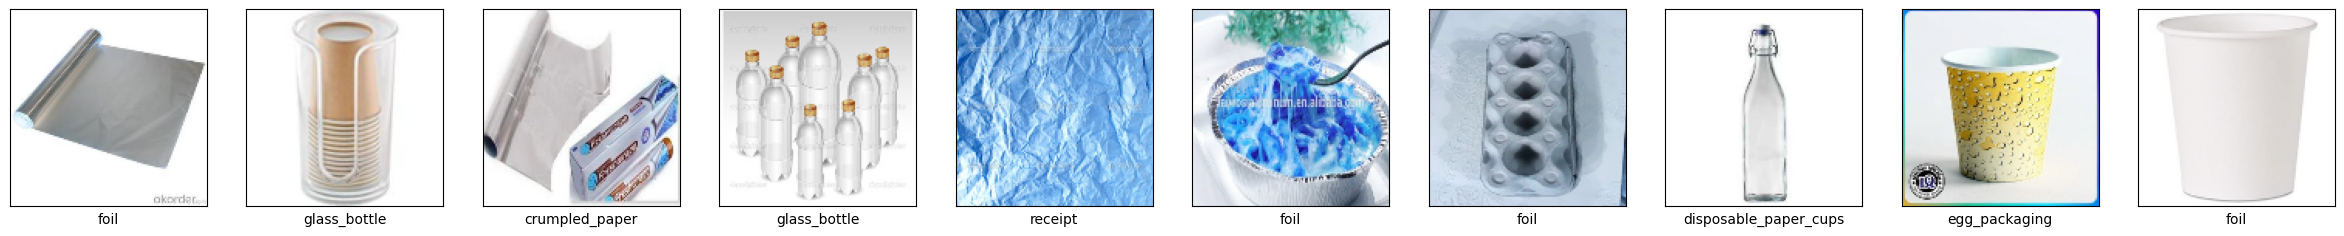

In [5]:
# class_names
def show_images(images, labels, class_names, num_images=10):
    num_images = min(num_images, len(images))

    plt.figure(figsize=(30, 20))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        label_index = np.argmax(labels[i])
        plt.xlabel(class_names[label_index])

    plt.show()

# Affiche les 10 premières images d'entraînement et leurs étiquettes correspondantes
show_images(train_val_images, train_labels, class_names, num_images=10)

### **II. TRAINING AND EVALUATION**

### **1. CNN modèle**

In [ ]:
def build_cnn_model():
  """
  Cette fonction nous permet de créer un modèle CNN avec des couches personnalisées
  """
#Utilisation de BatchNormalization, Dropout et Maxpooling pour éviter l'overfitting:
#BatchNormalization aide le modèle à apprendre plus rapidement et de manière plus stable en normalisant les sorties des couches
#Dropout réduit le risque de surapprentissage en éteignant aléatoirement des neurones pendant l'entraînement
#MaxPooling diminue la taille des images tout en gardant les informations importantes, ce qui rend le modèle plus rapide et moins complexe.


  cnn_model = Sequential([
      Conv2D(32, (3, 3), padding = 'same', activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.05)),       #, kernel_regularizer=l2(0.01)
      BatchNormalization(),
      # Dropout(0.3),
      MaxPooling2D((2, 2)),

      Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l2(0.05)),                                  #, kernel_regularizer=l2(0.01)
      BatchNormalization(),
      # Dropout(0.3),
      MaxPooling2D((2, 2)),

      Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.05)),
      BatchNormalization(),
      MaxPooling2D((2, 2)),

      Flatten(),
      Dense(128, activation='relu', kernel_regularizer=l2(0.05)),

      Dropout(0.5),   # 0.2
      Dense(len(class_names), activation='softmax')
  ])

  return cnn_model

cnn_model = build_cnn_model()

# Initialise le modèle en lui passant une donnée
cnn_model.predict(train_images[[0]])

1/1 [==============================] - 0s 104ms/step


array([[0.11325066, 0.12885755, 0.16652276, 0.16823798, 0.17541867,
        0.13757075, 0.11014171]], dtype=float32)

In [ ]:
# Compile le modèle
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Ajout de earlystopping, et reduce_lr afin de limiter l'overfitting
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=32)   #, restore_best_weights=True
mc = ModelCheckpoint('cnn_model_best.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1) # factor=0.1 et patience=3

# Entraîne le modèle
history = cnn_model.fit(train_images, train_labels,
                        epochs=40,
                        validation_data=(val_images, val_labels),
                        batch_size=32,
                        callbacks=[es, mc, reduce_lr])   # , reduce_lr

Epoch 1/40
45/47 [===========================>..] - ETA: 0s - loss: 4.0174 - accuracy: 0.4236
Epoch 1: val_accuracy improved from -inf to 0.34595, saving model to cnn_model_best.h5
47/47 [==============================] - 5s 49ms/step - loss: 4.0407 - accuracy: 0.4245 - val_loss: 5.6545 - val_accuracy: 0.3459 - lr: 0.0010
Epoch 2/40
47/47 [==============================] - ETA: 0s - loss: 3.6973 - accuracy: 0.4766
Epoch 2: val_accuracy improved from 0.34595 to 0.50811, saving model to cnn_model_best.h5
47/47 [==============================] - 1s 32ms/step - loss: 3.6973 - accuracy: 0.4766 - val_loss: 2.9585 - val_accuracy: 0.5081 - lr: 0.0010
Epoch 3/40
46/47 [============================>.] - ETA: 0s - loss: 2.7159 - accuracy: 0.4749
Epoch 3: val_accuracy did not improve from 0.50811
47/47 [==============================] - 1s 27ms/step - loss: 2.7159 - accuracy: 0.4739 - val_loss: 2.8863 - val_accuracy: 0.3919 - lr: 0.0010
Epoch 4/40
46/47 [============================>.] - ETA: 0s -

> Les scores sont aux alentours de :  loss: 0.4917 - accuracy: 0.9709 - val_loss: 1.2728 - val_accuracy: 0.7297.

In [ ]:
# Évalue le modèle sur les données de test
test_loss, test_accuracy = cnn_model.evaluate(test_images, test_labels)
print("Précision sur les données de test :", test_accuracy)

15/15 [==============================] - 0s 27ms/step - loss: 1.2204 - accuracy: 0.7229
Précision sur les données de test : 0.7229437232017517


> **Test 1** : Epoch 10/10
41/41 [==============================] - 60s 1s/step - loss: 0.6061 - accuracy: 0.7825 - val_loss: 1.4950 - val_accuracy: 0.6173
22/22 [==============================] - 7s 305ms/step - loss: 1.6832 - accuracy: 0.5671
Précision sur les données de test : 0.5670995712280273

> **2e exec** : Epoch 19/20
6/6 [==============================] - 48s 8s/step - loss: 0.8181 - accuracy: 0.7121 - val_loss: 1.3756 - val_accuracy: 0.6049
Epoch 20/20

> **TEST 2** : Epoch 40/40
6/6 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9613
Epoch 40: val_accuracy did not improve from 0.65123
6/6 [==============================] - 48s 8s/step - loss: 0.1339 - accuracy: 0.9613 - val_loss: 1.8106 - val_accuracy: 0.6111

> ""**TEST 3**"" : dropout(0.3), ajout de 1 batchnormalisation et padding = 'same', et **test_size==20%** : Epoch 40/40
11/12 [==========================>...] - ETA: 0s - loss: 0.0137 - accuracy: 0.9972
Epoch 40: val_accuracy did not improve from 0.64324
12/12 [==============================] - 1s 73ms/step - loss: 0.0135 - accuracy: 0.9973 - val_loss: 1.5324 - val_accuracy: 0.6054

> **TEST4** 1 dropout(0.2) et 3 batchnorm, batch size(32), patience=16 et reduce_lr(0.5, 5) : train=0.98 et test=0.71

> **TEST 5 : droupout(0.5) et kernel_regularizer=l2(0.02), batch, batch size(32), patience(16),  reduce_lr(0.5, 5)** :\
Epoch 40/40
46/47 [============================>.] - ETA: 0s - loss: 1.0230 - accuracy: 0.7758
Epoch 40: val_accuracy improved from 0.65676 to 0.66757, saving model to cnn_model_best.h5
47/47 [==============================] - 2s 34ms/step - loss: 1.0229 - accuracy: 0.7759 - val_loss: 1.4912 - val_accuracy: 0.6676 - lr: 2.5000e-04

> **TEST 6 : droupout(0.5) et kernel_regularizer=l2(0.05), batch, batch size(32), patience(32),  reduce_lr(0.5, 5)** :\
Epoch 40/40
45/47 [===========================>..] - ETA: 0s - loss: 0.4929 - accuracy: 0.9701
Epoch 40: val_accuracy did not improve from 0.72973
47/47 [==============================] - 1s 27ms/step - loss: 0.4917 - **accuracy: 0.9709** - val_loss: 1.2728 - **val_accuracy: 0.7297** - lr: 1.2500e-04

**On va par la suite opter pour le transfer learning soit utiliser des modèles déjà pré-entraînés.**

### **2. VGG19**

In [ ]:
vgg19_model = keras.applications.VGG19(
    input_shape=(128,128,3),
    include_top=False,
    weights="imagenet"
)

In [ ]:
# vgg19_model.summary()

# Gel des couches de base du modèle
vgg19_model.trainable = False

# Ajout des couches de classification
x = vgg19_model.output
x = GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)      ##
x = Dense(128, activation='relu', kernel_regularizer=l2(0.05))(x)   ##
x = Dropout(0.3)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Crée le modèle final
transf_vgg19_model = tf.keras.Model(vgg19_model.input, predictions)

transf_vgg19_model.compile(optimizer='adam',              # tf.keras.optimizers.Adam(learning_rate=1e-3)
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# on ajoute earlystopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=32, restore_best_weights=True)    # , restore_best_weights=True
mc = ModelCheckpoint('vgg19_model_best.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = transf_vgg19_model.fit(train_images, train_labels,
                                 validation_data=(val_images, val_labels),
                                 batch_size=32,
                                 epochs=40,
                                 callbacks=[es, mc])

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.9949 - accuracy: 0.2454  
Epoch 1: val_accuracy improved from -inf to 0.18519, saving model to vgg19_model_best.h5
11/11 [==============================] - 1397s 127s/step - loss: 1.9949 - accuracy: 0.2454 - val_loss: 22.2047 - val_accuracy: 0.1852
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.7495 - accuracy: 0.2949  
Epoch 2: val_accuracy did not improve from 0.18519
11/11 [==============================] - 1393s 127s/step - loss: 1.7495 - accuracy: 0.2949 - val_loss: 17.0383 - val_accuracy: 0.1852
Epoch 3/30
 6/11 [===============>..............] - ETA: 10:11 - loss: 1.6742 - accuracy: 0.3385

> **test 1 avec batsh size=256, patience=128** : poch 20: val_accuracy did not improve from 0.35494
6/6 [==============================] - 7s 1s/step - loss: 1.4305 - accuracy: 0.4458 - val_loss: 2.4584 - val_accuracy: 0.2130

> **test 2 avec batch size = 64 et patience=32** : Epoch 27/30
21/21 [==============================] - ETA: 0s - loss: 0.4271 - accuracy: 0.8444
Epoch 27: val_accuracy improved from 0.55556 to 0.60185, saving model to vgg19_model_best.h5
21/21 [==============================] - 8s 378ms/step - loss: 0.4271 - accuracy: 0.8444 - val_loss: 1065250.1250 - val_accuracy: 0.6019

> **test 3 avec batch size = 128 et patience=64** : Epoch 30: val_accuracy improved from 0.61420 to 0.63580, saving model to vgg19_model_best.h5
11/11 [==============================] - 7s 681ms/step - loss: 0.0093 - accuracy: 0.9985 - val_loss: 1.6737 - val_accuracy: 0.6358

### **3. EfficientNetb2**

In [ ]:
base_model = tf.keras.applications.EfficientNetB2(
    input_shape=(128,128,3),
    include_top=False,        # on va définir des couches personnalisées ci après
    weights="imagenet"
)

In [ ]:
# base_model.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 128, 128, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 128, 128, 3)          0         ['normalization[0

In [ ]:
# Gel des couches de base du modèle
base_model.trainable = False

# Ajout de couches personnalisées de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)                # , kernel_regularizer=tf.keras.regularizers.l2(0.01)
# x = Dropout(0.3)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Crée le modèle final
transf_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
transf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# on ajoute earlystopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=32)    # , restore_best_weights=True
mc = ModelCheckpoint('efficientnetb2_model_best.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# entrainement
history = transf_model.fit(train_images, train_labels,
                           validation_data=(val_images, val_labels),
                           batch_size=32,
                           epochs=40,
                           callbacks=[es, mc])      # , reduce_lr

Epoch 1/40
46/47 [============================>.] - ETA: 0s - loss: 1.8932 - accuracy: 0.1977
Epoch 1: val_accuracy improved from -inf to 0.19189, saving model to efficientnetb2_model_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 16s 147ms/step - loss: 1.8929 - accuracy: 0.1977 - val_loss: 1.8608 - val_accuracy: 0.1919
Epoch 2/40
45/47 [===========================>..] - ETA: 0s - loss: 1.8568 - accuracy: 0.2076
Epoch 2: val_accuracy did not improve from 0.19189
47/47 [==============================] - 2s 42ms/step - loss: 1.8566 - accuracy: 0.2079 - val_loss: 1.8793 - val_accuracy: 0.1919
Epoch 3/40
47/47 [==============================] - ETA: 0s - loss: 1.8601 - accuracy: 0.2051
Epoch 3: val_accuracy did not improve from 0.19189
47/47 [==============================] - 2s 42ms/step - loss: 1.8601 - accuracy: 0.2051 - val_loss: 1.8663 - val_accuracy: 0.1919
Epoch 4/40
47/47 [==============================] - ETA: 0s - loss: 1.8496 - accuracy: 0.2112
Epoch 4: val_accuracy improved from 0.19189 to 0.19730, saving model to efficientnetb2_model_best.h5
47/47 [==============================] - 3s 60ms/step - loss: 1.8496 - accuracy: 0.2112 - val_loss: 1.8622 - val_accuracy: 

> **Test 1** : Epoch 20/20
41/41 [==============================] - 6s 150ms/step - loss: 0.1029 - accuracy: 0.9721 - val_loss: 3.3988 - val_accuracy: 0.1111

> **Test 2** : Epoch 20/20
12/12 [==============================] - 2s 143ms/step - loss: 0.5817 - accuracy: 0.8488 - val_loss: 3.2545 - val_accuracy: 0.2092

> **Test 3** : Epoch 20/20
11/11 [==============================] - 1s 70ms/step - loss: 0.3519 - accuracy: 0.9180 - val_loss: 2.5260 - val_accuracy: 0.2222

In [ ]:
# Evaluation
test_loss, test_acc = transf_model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

22/22 [==============================] - 0s 15ms/step - loss: 3.2545 - accuracy: 0.2092
Test accuracy: 0.20923520624637604


> Ce modèle est beaucoup moins performant que les autres.

### **III. MAKE PREDICTIONS**

### **1. CNN MODEL**

In [ ]:
# Charger le modèle enregistré si l'entrainement a déjà ete fait
cnn_model_best = tf.keras.models.load_model('/content/cnn_model_best.h5')

In [ ]:
predictions = cnn_model.predict(test_images)

15/15 [==============================] - 0s 8ms/step


In [ ]:
# Predicted label for the 1st image
predictions[0]

array([0.00787316, 0.0578599 , 0.00748012, 0.02037322, 0.48836094,
       0.4166022 , 0.00145046], dtype=float32)

In [ ]:
# Class that has the highest confidence
prediction = np.argmax(predictions[0])
print(class_names[prediction])

plastic_bottle


Label of this image is: plastic_bottle


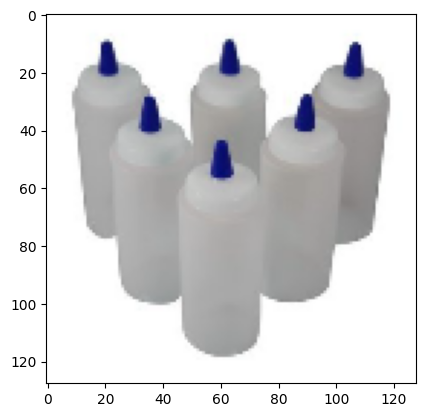

In [ ]:
# To verify if the prediction is correct
print("Label of this image is:",class_names[np.argmax(test_labels[0])])
plt.imshow(test_images[0])

In [ ]:
# Fonctions pour afficher les prédictions avec la probabilité de confiance
def plot_image_prediction(i, predictions_array, class_names, true_label, img):

  predictions_array, true_label, img = predictions_array[i], np.argmax(true_label[i]), img[i]

  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)

  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)



def plot_value_prediction(i, predictions_array, class_names, true_label):

  predictions_array, true_label = predictions_array[i], np.argmax(true_label[i])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")

  plt.ylim([0, 1])

  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

  plt.xticks(range(len(class_names)),
             class_names,
             rotation=45,
             ha='right')


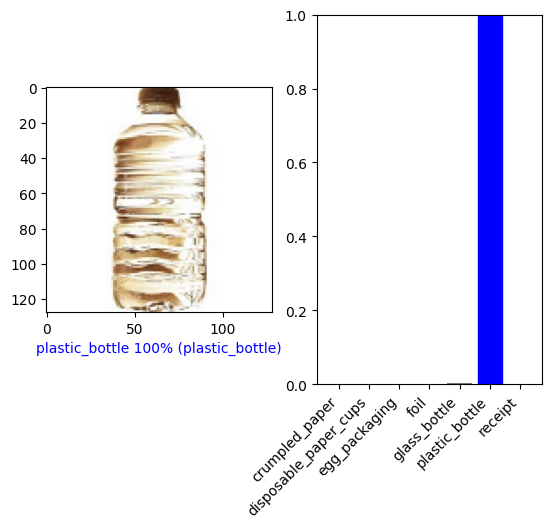

In [ ]:
# Pour voir les prédictions du modèle
#@title Changer le slider pour observer les prédictions du modèle CNN classique! { run: "auto" }

image_index = 96 #@param {type:"slider", min:0, max:100, step:1}

plt.subplot(1,2,1)
plot_image_prediction(image_index, predictions, class_names, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_prediction(image_index, predictions, class_names, test_labels)

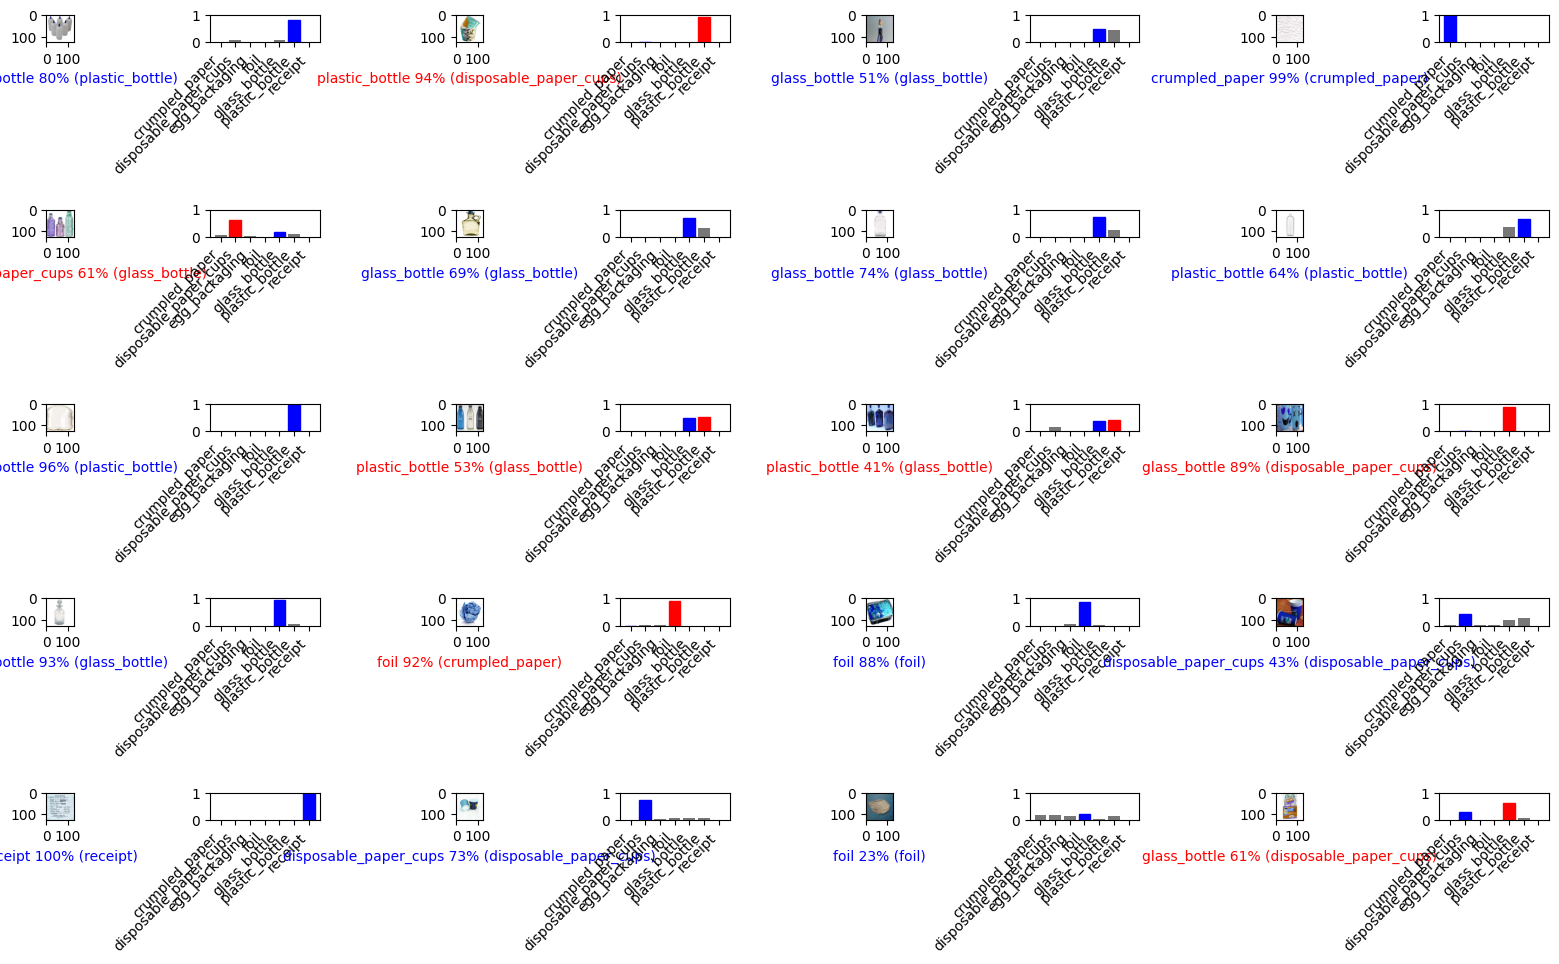

In [ ]:
# affiche les premières images de test, leur étiquette prédite, et l'étiquette réelle
# affiche les prédictions correctes en bleu et les prédictions incorrectes en rouge
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image_prediction(i, predictions, class_names,test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_prediction(i, predictions, class_names,test_labels)
  plt.tight_layout(pad=2.0)  # Adjust the spacing between rows

### **2. VGG16 MODEL**

# Le modèle retenu et qui sera intégré dans la webapp est le VGG16

In [7]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # 7 classes donc 7 neurones dans la dernière couche dense


model = Model(inputs=base_model.input, outputs=predictions)

# on gèle les couches convolutionnelles de VGG16 pour ne pas les réentraîner initialement
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle initialement avec les couches gelées
history = model.fit(train_images, train_labels, batch_size=32, epochs=10, validation_data=(val_images, val_labels))

# Évaluation des performances du modèle sur l'ensemble de test
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Score de test: Loss={test_loss}, Accuracy={test_acc}')


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
46/46 [==============================] - 15s 168ms/step - loss: 1.6916 - accuracy: 0.4079 - val_loss: 0.9047 - val_accuracy: 0.7228
Epoch 2/10
46/46 [==============================] - 2s 50ms/step - loss: 0.9972 - accuracy: 0.6329 - val_loss: 0.7319 - val_accuracy: 0.7283
Epoch 3/10
46/46 [==============================] - 2s 50ms/step - loss: 0.7542 - accuracy: 0.7247 - val_loss: 0.6480 - val_accuracy: 0.7745
Epoch 4/10
46/46 [==============================] - 3s 55ms/step - loss: 0.6181 - accuracy: 0.7784 - val_loss: 0.6480 - val_accuracy: 0.7527
Epoch 5/10
46/46 [==============================] - 3s 55ms/step - loss: 0.5349 - accuracy: 0.8001 - val_loss: 0.6113 - val_accuracy: 0.7799
Epoch 6/10
46/46 [==============================] - 2s 52ms/step - loss: 0.4259 - accuracy: 0.8470 - val_loss: 0.6331 - val_accuracy: 0.7962
Epoch 7/10
46/46 [==============================] - 2s 50ms/step - loss: 0.3681 - accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Il y a un peu d'overfitting, pour le réduire on va ajouter
- un Early stopping en fixant la patience à 3 ce qui signifie que si on a pas d'amélioration au niveau de la performance de validation au bout de 3 époques consécutives alors l'entraînement du modèle s'arrête.
- Un générateur d'augmentation de données : pour créer de nouvelles images à partir des images d'entraînement existantes (en les tournant, zoomant, etc.). Ainsi on a plus de données et ça réduit le risque que le modèle mémorise les données d'entraînement.

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # 7 classes donc 7 neurones dans la dernière couche dense


model = Model(inputs=base_model.input, outputs=predictions)

# on gèle les couches convolutionnelles de VGG16 pour ne pas les réentraîner initialement pour préserver les poids appris lors de l'entraînement sur ImageNet
for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Création d'un générateur d'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# on ajuste le générateur sur les images d'entraînement
datagen.fit(train_images)

# on entraîne le modèle avec l'augmentation des données
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
                    steps_per_epoch=len(train_images) // 32,
                    epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Score de test: Loss={test_loss}, Accuracy={test_acc}')

# Sauvegarde du modèle entraîné
model.save('vgg16_trained_model.h5')

# Évaluation des performances du modèle
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Score de test après fine-tuning: Loss={test_loss}, Accuracy={test_acc}')


Epoch 1/30
45/45 [==============================] - 10s 189ms/step - loss: 1.9127 - accuracy: 0.3329 - val_loss: 1.1798 - val_accuracy: 0.5870
Epoch 2/30
45/45 [==============================] - 6s 142ms/step - loss: 1.3094 - accuracy: 0.5129 - val_loss: 0.8046 - val_accuracy: 0.7011
Epoch 3/30
45/45 [==============================] - 7s 154ms/step - loss: 1.1108 - accuracy: 0.5844 - val_loss: 0.7433 - val_accuracy: 0.7228
Epoch 4/30
45/45 [==============================] - 8s 186ms/step - loss: 1.0597 - accuracy: 0.6039 - val_loss: 0.7610 - val_accuracy: 0.7228
Epoch 5/30
45/45 [==============================] - 6s 139ms/step - loss: 0.8808 - accuracy: 0.6706 - val_loss: 0.6597 - val_accuracy: 0.7283
Epoch 6/30
45/45 [==============================] - 6s 139ms/step - loss: 0.8304 - accuracy: 0.6880 - val_loss: 0.6430 - val_accuracy: 0.7636
Epoch 7/30
45/45 [==============================] - 8s 170ms/step - loss: 0.7788 - accuracy: 0.7123 - val_loss: 0.7507 - val_accuracy: 0.7418
Epoch